# 🛡️ PAN Card Tampering Detection Using Multiple Image Forensics Techniques

This notebook demonstrates a comprehensive approach to detecting tampered or forged PAN cards using a variety of classical and advanced computer vision techniques.

While many existing implementations rely solely on **Structural Similarity Index (SSIM)**, this project goes beyond — incorporating multiple methods for robust forgery analysis:

- 🔍 **Image Subtraction** — Highlights pixel-level differences.
- 📉 **Peak Signal-to-Noise Ratio (PSNR)** — Quantifies the quality degradation between original and suspected images.
- 🧠 **Feature-Based Matching**:
  - **SIFT (Scale-Invariant Feature Transform)**
  - **SURF (Speeded-Up Robust Features)**
  - **ORB (Oriented FAST and Rotated BRIEF)**  
These detect and compare keypoints to identify structural inconsistencies introduced during tampering.

The goal is to create a **stronger, multi-perspective detection system** that works across different types of PAN card image forgeries — including copy-paste edits, blurs, or text/image manipulation.

> ⚙️ This notebook can serve both as an academic resource for image forensics and a practical solution for document verification systems.

In [1]:
import cv2 
import numpy as np
from PIL import Image
import imutils
import requests
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity

# Download and Save Images

In [2]:
# making empty directories
!mkdir pan_card_tampering
!mkdir pan_card_tampering/image

In [3]:
original = Image.open(requests.get('https://www.thestatesman.com/wp-content/uploads/2019/07/pan-card.jpg', stream = True).raw) 
tampered = Image.open(requests.get('https://assets1.cleartax-cdn.com/s/img/20170526124335/Pan4.png', stream = True).raw)              

In [4]:
# Formats
print("Original Image ", original.format)
print("Tampered Image ", tampered.format)

# Sizes
print("Original Image ", original.size)
print("Tampered Image ", tampered.size)

Original Image  JPEG
Tampered Image  PNG
Original Image  (1200, 800)
Tampered Image  (282, 179)


#### Resize images to same size

In [5]:
# Resizing and Save Images
original = original.resize((250, 160))
original.save('pan_card_tampering/image/original.png') 

tampered = tampered.resize((250, 160))
tampered.save('pan_card_tampering/image/tampered.png')

In [6]:
print(f"Original Size: {original.size}\nTampered Size: {tampered.size}")

Original Size: (250, 160)
Tampered Size: (250, 160)


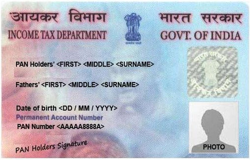

In [7]:
original

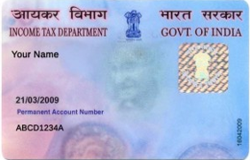

In [8]:
tampered

# Image Pre-Processing

## Convert images to CV2 images

In [9]:
original_cv = cv2.imread("/kaggle/working/pan_card_tampering/image/original.png")
tampered_cv = cv2.imread("/kaggle/working/pan_card_tampering/image/tampered.png")

#### Convert images to Gray Scale

In [10]:
original_gray = cv2.cvtColor(original_cv, cv2.COLOR_BGR2GRAY)
tampered_gray = cv2.cvtColor(tampered_cv, cv2.COLOR_BGR2GRAY)

# Detecting Difference

## Using SSIM (structured similarity index)

In [11]:
# Computing SS Index (SSIM) between the Original and Tampered images
(score, diff) = structural_similarity(original_gray, tampered_gray, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

SSIM: 0.3168613569048913


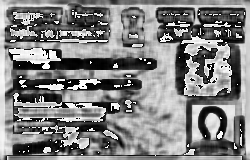

In [12]:
Image.fromarray(diff)

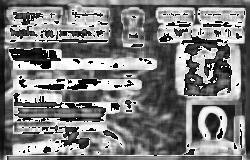

In [13]:
diff = (diff * 255).astype("uint8")
Image.fromarray(diff)

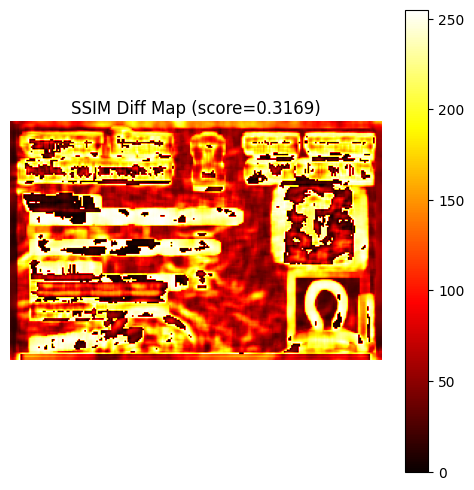

In [14]:
plt.figure(figsize=(6, 6))
plt.imshow(diff, cmap='hot')  # or 'jet', 'viridis'
plt.colorbar()
plt.title(f"SSIM Diff Map (score={score:.4f})")
plt.axis('off')
plt.show()

### Draw Contours on Tampered Area

In [15]:
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on a copy of tampered image
annotated = tampered_cv.copy()
cv2.drawContours(annotated, contours, -1, (0, 0, 255), 2)
# Convert grayscale diff to RGB
colored_diff = cv2.applyColorMap(diff, cv2.COLORMAP_JET)
overlay = cv2.addWeighted(original_cv, 0.6, colored_diff, 0.4, 0)

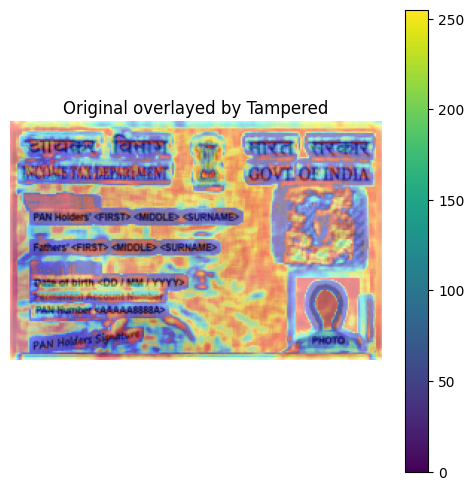

In [16]:
plt.figure(figsize=(6, 6))
plt.imshow(overlay) 
plt.colorbar()
plt.title(f"Original overlayed by Tampered")
plt.axis('off')
plt.show()

## Using Image Substraction
Subtraction will highlight the areas that do not match in the images, in case both images are the same it will result in a whole black image. 

### Subtract original from original

In [17]:
subtract_result = cv2.subtract(original_cv, original_cv)

Text(0.5, 1.0, 'Image Substraction Result')

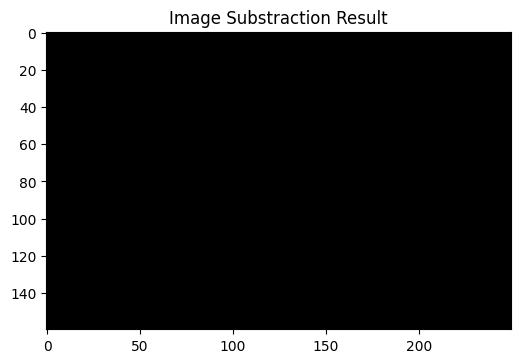

In [18]:
plt.figure(figsize=(6,6))
plt.imshow(subtract_result)
plt.title("Image Substraction Result")

In [19]:
subtract_result = cv2.subtract(original_cv, tampered_cv)

Text(0.5, 1.0, 'Image Substraction Result')

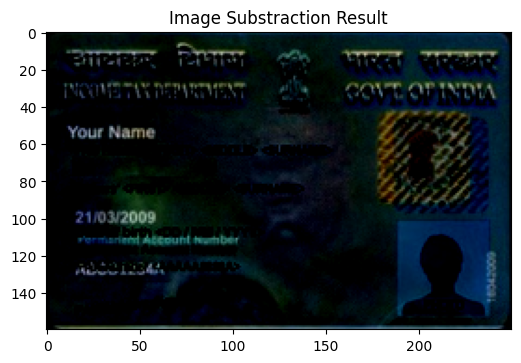

In [20]:
plt.figure(figsize=(6,6))
plt.imshow(subtract_result)
plt.title("Image Substraction Result")

## Using PSNR (Peak Signal-to-Noise Ratio)
**PSNR**, or **Peak Signal-to-Noise Ratio**, is a metric used to assess the quality of a reconstructed image or signal after compression or other processing.
| PSNR (dB) | Meaning (in general)                           |
| --------- | ---------------------------------------------- |
| **> 40**  | Almost identical (visually lossless)           |
| **30–40** | High quality (small changes, hard to notice)   |
| **20–30** | Moderate quality (visible changes)             |
| **10–20** | Low quality (obvious tampering or compression) |
| **< 10**  | Very poor, likely unusable                     |

**[Learn more on Wikipedia](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)**

In [21]:
psnr = cv2.PSNR(original_cv, tampered_cv)
print(f"Image PSNR is: {psnr}")

Image PSNR is: 14.75521494495517


## Feature-Based Difference Detection (SIFT/SURF/ORB + Matching)

### SIFT (Scale-Invariant Feature Transform)

It’s a powerful algorithm that detects and describes local keypoints (like corners, blobs, edges) in an image — regardless of:

- Scale (zoom level),
- Rotation,
- Illumination.



Learn more about SIFT at 

- **[OpenCV Documentation](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html)**

In [22]:
type(original_gray), type(tampered_gray)

(numpy.ndarray, numpy.ndarray)

In [23]:
assert original_gray is not None, "Original image not loaded"
assert tampered_gray is not None, "Tampered image not loaded"

In [25]:
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
kp1, des1 = sift.detectAndCompute(original_gray, None)
kp2, des2 = sift.detectAndCompute(tampered_gray, None)

# Match 
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test to find good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

In [26]:
print(f"Found {len(good_matches)} good matches.")

Found 84 good matches.


#### visualize

Draw small circles using the drawMatches() function around the keypoints.

In [27]:
# Draw keypoints on both images
original_kp_image = cv2.drawKeypoints(
    original_gray, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

tampered_kp_image = cv2.drawKeypoints(
    tampered_gray, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

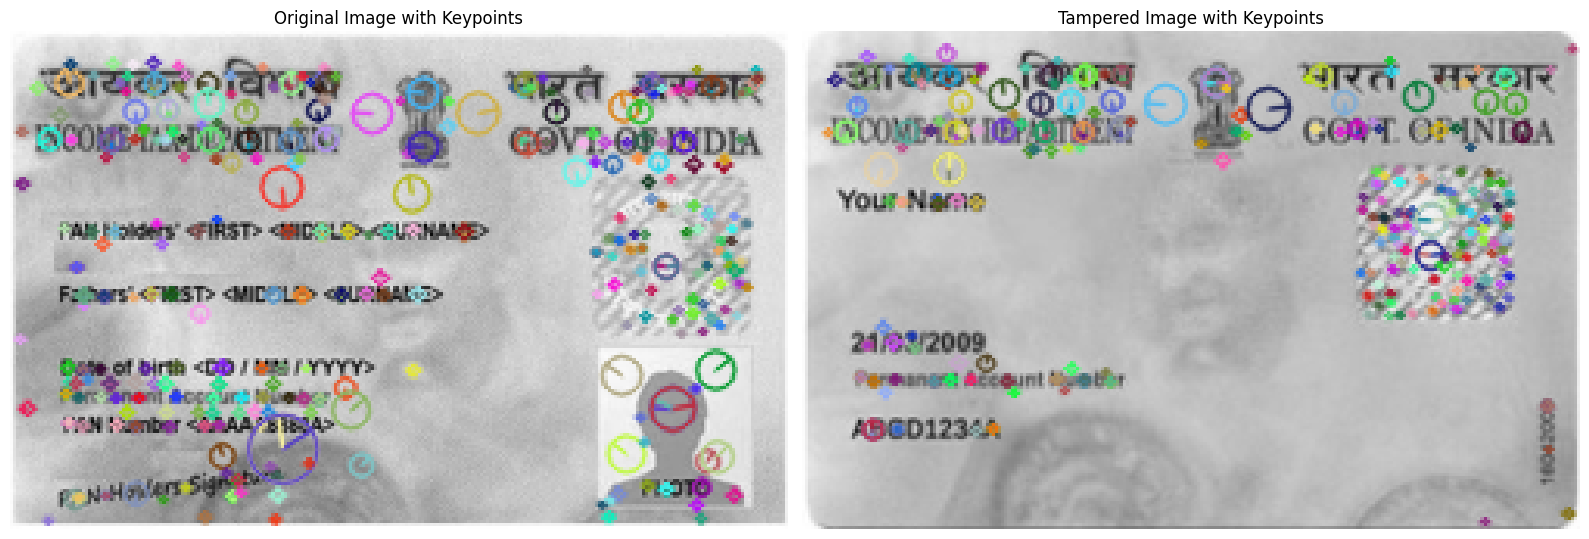

In [28]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(original_kp_image, cmap='gray')
plt.title("Original Image with Keypoints")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tampered_kp_image, cmap='gray')
plt.title("Tampered Image with Keypoints")
plt.axis('off')

plt.tight_layout()
plt.show()

### ORB (Oriented FAST and Rotated BRIEF)
ORB gives you:
- **Keypoints:** Distinctive features (corners, edges) in an image.
- **Descriptors:** Binary vectors (like 256 bits) that describe the region around each keypoint.
- **Matches:** Pairs of similar descriptors across two images.

In [29]:
# ORB works with binary descriptors (need NORM_HAMMING)
orb = cv2.ORB_create(nfeatures=1000)

# Detect and compute
kp1, des1 = orb.detectAndCompute(original_gray, None)
kp2, des2 = orb.detectAndCompute(tampered_gray, None)

# Brute-force matcher for ORB
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match and sort by distance
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

In [30]:
# After matching
similarity_score = len(good_matches) / min(len(kp1), len(kp2))
print(f"Similarity Score: {similarity_score}")

Similarity Score: 0.21052631578947367


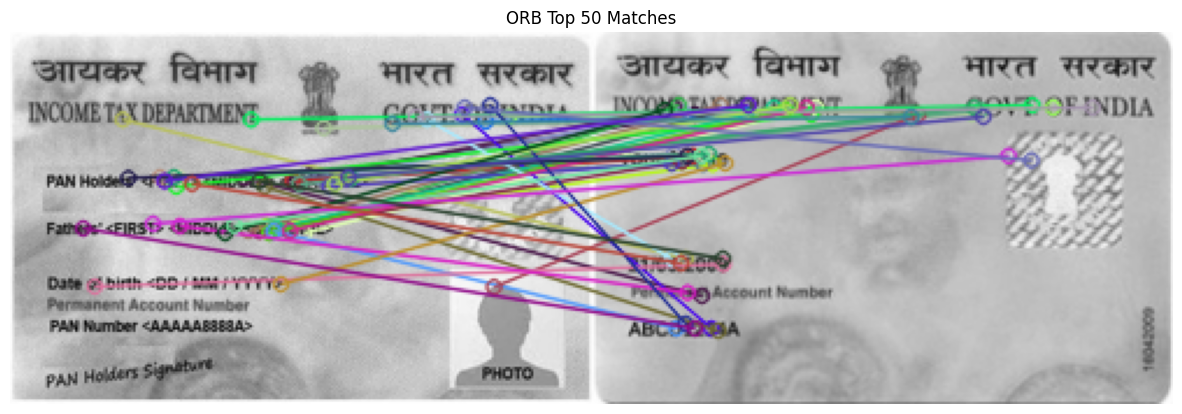

In [31]:
# Draw top N matches (optional)
top_n = 50
matched_img = cv2.drawMatches(original_gray, kp1, tampered_gray, kp2,
                              matches[:top_n], None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show
plt.figure(figsize=(15, 7))
plt.imshow(matched_img)
plt.title(f"ORB Top {top_n} Matches")
plt.axis('off')
plt.show()

### SURF (Speeded-Up Robust Features)
It's a local feature detector and descriptor algorithm used for various tasks like object recognition, image registration, and 3D reconstruction. SURF is known for its speed and robustness, making it a popular choice for image analysis. 

Know more about **SURF** at
- **[Open CV Documentation](https://docs.opencv.org/3.4/df/dd2/tutorial_py_surf_intro.html)**

#### Error:

- "module 'cv2.cv2' has no attribute 'xfeatures2d'”.[See on Stackoverflow](https://stackoverflow.com/questions/64525121/sift-surf-module-cv2-cv2-has-no-attribute-xfeatures2d-set-opencv-enabl/64525431)

#### Downgrade OpenCv to resolve Error

In [ ]:
!pip index versions opencv-python

In [ ]:
!pip install opencv-python==3.4.17.63

In [ ]:
surf = cv2.xfeatures2d.SURF_create()

In [ ]:
# Detect keypoints and descriptors
kp1, des1 = surf.detectAndCompute(original_gray, None)
kp2, des2 = surf.detectAndCompute(tampered_gray, None)

# Brute-force matcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

In [ ]:
print(f"Found {len(good_matches)} good matches.")

In [ ]:
# Draw matches
matched_img = cv2.drawMatches(original, kp1, tampered, kp2, good_matches, None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show
plt.figure(figsize=(15, 7))
plt.imshow(matched_img)
plt.title(f"SURF Good Matches: {len(good_matches)}")
plt.axis('off')
plt.show()